In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, plot_roc_curve, plot_confusion_matrix


In [33]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [35]:
train.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [36]:
train.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [37]:
train.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [38]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


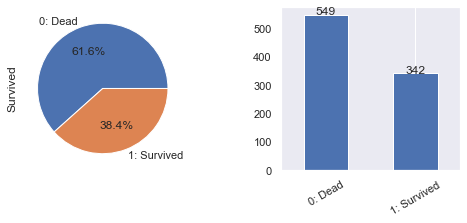

In [40]:
DICT_SURVIVED = {0: '0: Dead', 1: '1: Survived'}


def arrange_bar(ax, sr):
    ax.set_xticklabels(labels=ax.get_xticklabels(),
                       rotation=30, horizontalalignment="center")
    ax.grid(axis='y', linestyle='dotted')
    [ax.text(i, count, count, horizontalalignment='center')
     for i, count in enumerate(sr)]


sr_survived = train['Survived'].value_counts().rename(DICT_SURVIVED)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
sr_survived.plot.pie(autopct="%1.1f%%", ax=axes[0])
sr_survived.plot.bar(ax=axes[1])

arrange_bar(axes[1], sr_survived)

plt.show()


In [41]:
def arrange_stack_bar(ax):
    ax.set_xticklabels(labels=ax.get_xticklabels(),
                       rotation=30, horizontalalignment="center")
    ax.grid(axis='y', linestyle='dotted')


def output_bars(df, column, index={}):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # Key-Valueラベルなしの場合
    if len(index) == 0:
        df_vc = df.groupby([column])["Survived"].value_counts(
            sort=False).unstack().rename(columns=DICT_SURVIVED)
        df[column].value_counts().plot.pie(ax=axes[0, 0], autopct="%1.1f%%")
        df.groupby([column])["Survived"].value_counts(
            sort=False, normalize=True).unstack().rename(columns=DICT_SURVIVED).plot.bar(ax=axes[1, 1], stacked=True)

    # Key-Valueラベルありの場合
    else:
        df_vc = df.groupby([column])["Survived"].value_counts(
            sort=False).unstack().rename(index=index, columns=DICT_SURVIVED)
        df[column].value_counts().rename(index).plot.pie(
            ax=axes[0, 0], autopct="%1.1f%%")
        df.groupby([column])["Survived"].value_counts(
            sort=False, normalize=True).unstack().rename(index=index, columns=DICT_SURVIVED).plot.bar(ax=axes[1, 1], stacked=True)

    df_vc.plot.bar(ax=axes[1, 0])

    for rect in axes[1, 0].patches:
        height = rect.get_height()

        # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
        axes[1, 0].annotate('{:.0f}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    df_vc.plot.bar(ax=axes[0, 1], stacked=True)

    arrange_stack_bar(axes[0, 1])
    arrange_stack_bar(axes[1, 0])
    arrange_stack_bar(axes[1, 1])

    # データラベル追加
    [axes[0, 1].text(i, item.sum(), item.sum(), horizontalalignment='center')
     for i, (_, item) in enumerate(df_vc.iterrows())]

    plt.show()


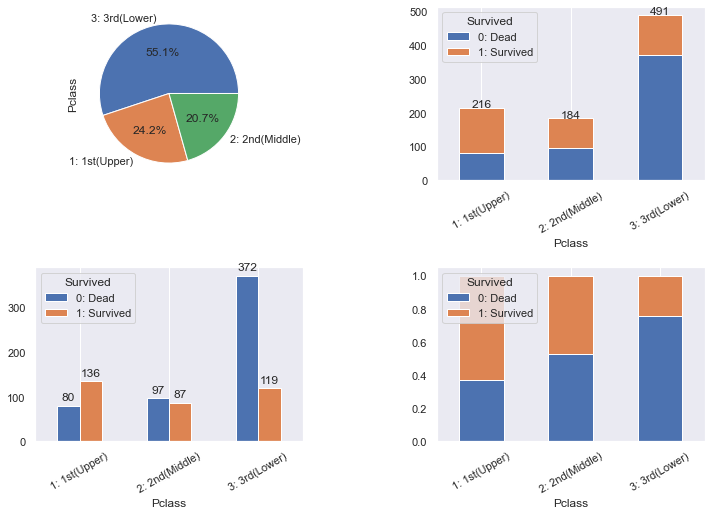

In [42]:
DICT_PCLASS = {1: '1: 1st(Upper)', 2: '2: 2nd(Middle)', 3: '3: 3rd(Lower)'}
output_bars(train, 'Pclass', DICT_PCLASS)


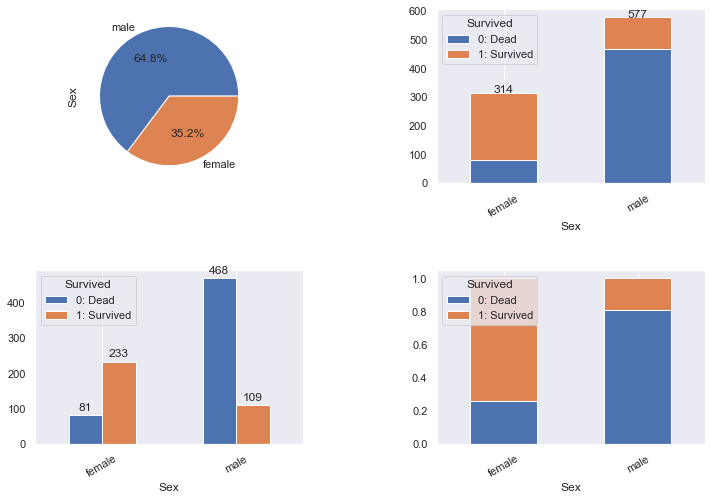

In [44]:
output_bars(train, 'Sex')


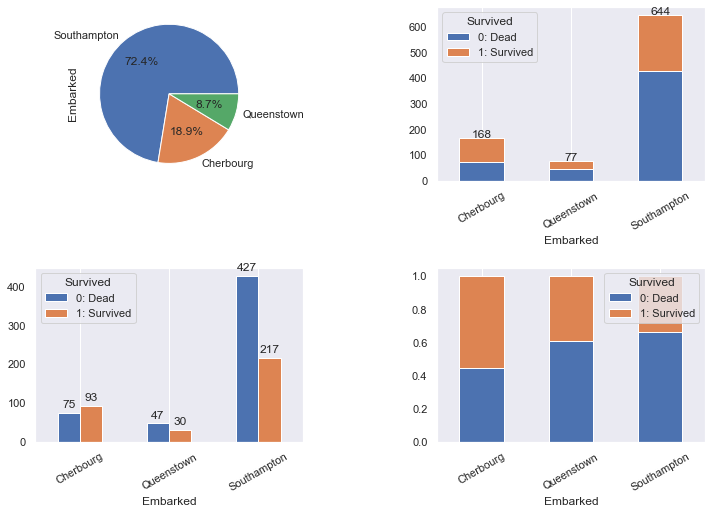

In [45]:
DICT_EMBARK = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}
output_bars(train, 'Embarked', DICT_EMBARK)


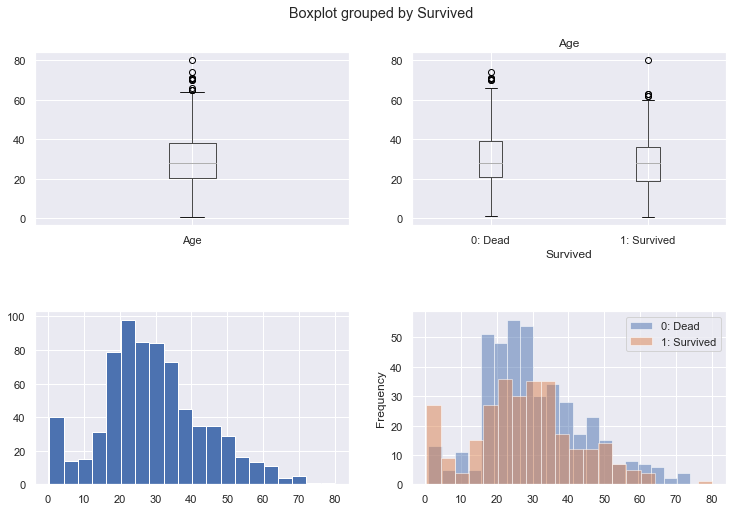

In [46]:
# 欠損値の扱い: 除去されている
def output_box_hist(column, bins=20, query=None):
    if query == None:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    else:
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
        train.query(query)[column].hist(ax=axes[2, 0], bins=bins)
        train.query(query).groupby('Survived')[column].plot.hist(
            ax=axes[2, 1], bins=bins, alpha=0.5, legend=True, grid=True)
        axes[2, 1].legend(labels=[DICT_SURVIVED[int(float((text.get_text())))]
                          for text in axes[2, 1].get_legend().get_texts()])

    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    train.boxplot(ax=axes[0, 0], column=[column])
    train.boxplot(ax=axes[0, 1], column=[column], by='Survived')
    axes[0, 1].set_xticklabels([DICT_SURVIVED[int(
        float(xticklabel.get_text()))] for xticklabel in axes[0, 1].get_xticklabels()])
    train[column].hist(ax=axes[1, 0], bins=bins)
    train.groupby('Survived')[column].plot.hist(
        ax=axes[1, 1], bins=bins, alpha=0.5, grid=True, legend=True)
    axes[1, 1].legend(labels=[DICT_SURVIVED[int(float((text.get_text())))]
                      for text in axes[1, 1].get_legend().get_texts()])

    plt.show()


output_box_hist('Age')


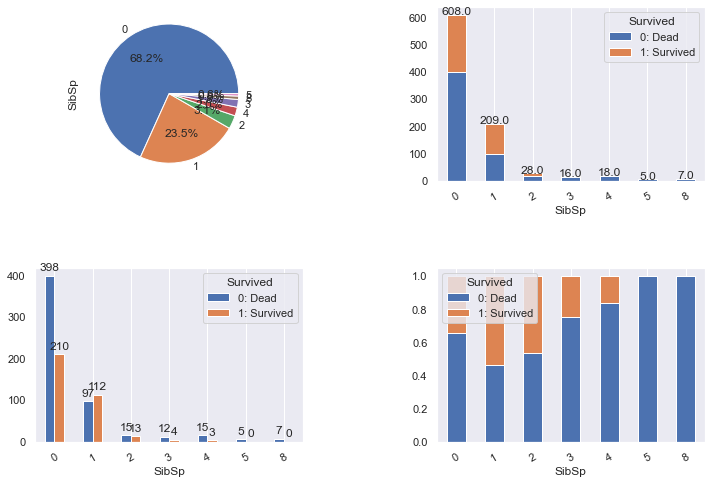

In [47]:
output_bars(train, 'SibSp')


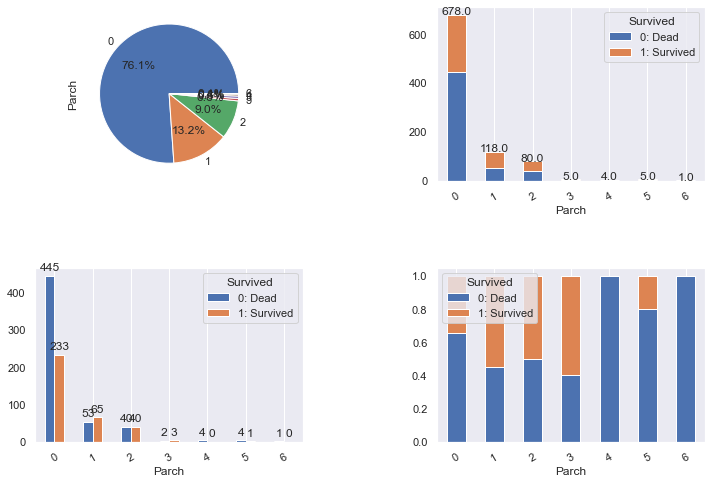

In [49]:
output_bars(train, 'Parch')


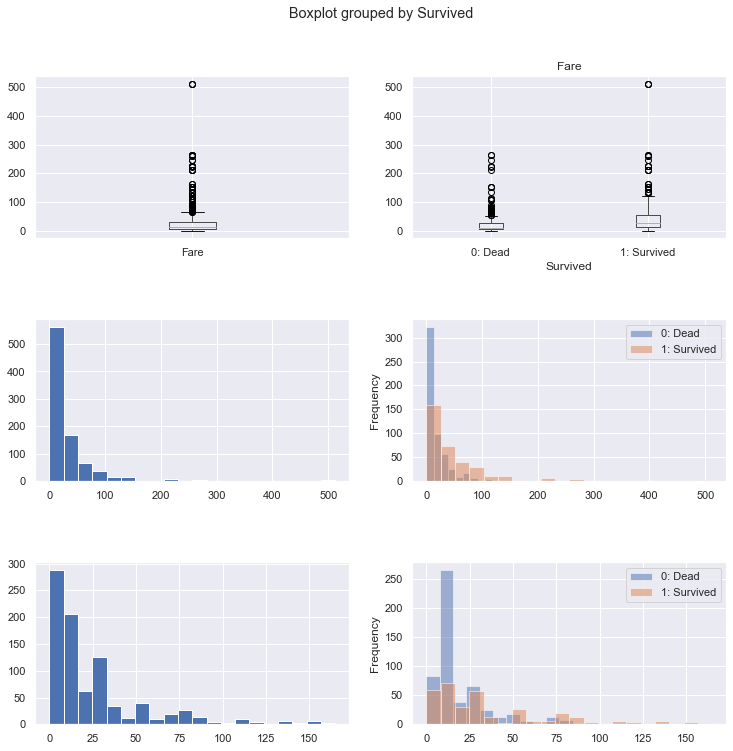

In [50]:
output_box_hist('Fare', 20, 'Fare < 200')


In [52]:
train.loc[:, ["Survived", "Pclass", "Age", "SibSp", "Parch",
                  "Fare"]].corr().style.background_gradient(axis=None)


,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [53]:
both = pd.concat([train, test], ignore_index=True)


In [54]:
# Last Name作成
both['Last_Name'] = both['Name'].apply(lambda x: str.split(x, ",")[0])

# FareがNullのレコードは文字列"nan"となる
both['Name_Fare'] = both['Last_Name'] + both['Fare'].astype('str')


In [55]:
# 姓とFareでグルーピング
def process_name(i, name_fare):
    tickets = both.loc[(both['Name_Fare'] == name_fare) & (
        both['Group'].isnull()), 'Ticket'].unique().tolist()
    both.loc[(both['Name_Fare'] == name_fare) & (
        both['Group'].isnull()), 'Group'] = i
    for ticket in tickets:
        process_ticket(i, ticket)

# チケットでグルーピング


def process_ticket(i, ticket):
    name_fares = both.loc[(both['Ticket'] == ticket) & (
        both['Group'].isnull()), 'Name_Fare'].unique().tolist()
    both.loc[(both['Ticket'] == ticket) & (
        both['Group'].isnull()), 'Group'] = i
    for name_fare in name_fares:
        process_name(i, name_fare)


both['Group'] = None

# チケットでグルーピング(再帰処理で姓とFare、チケットでのグルーピングを繰り返す)
[process_ticket(i, ticket)
 for i, ticket in enumerate(both['Ticket'].unique().tolist())]

print('Ticket Count', both['Ticket'].nunique())
print('Name & Fare Count', both['Name_Fare'].nunique())
print('Ticket & Name Count', both['Group'].nunique())


Ticket Count 929
Name & Fare Count 982
Ticket & Name Count 887


In [56]:
titles = ["Mr.", "Miss.", "Mrs.", "Master.", "Dr.", "Rev.", "Col.", "Ms.", 
          "Mlle.", "Mme.", "Capt.", "Countess.", "Major.", "Jonkheer.", "Don.", 
         "Dona.", "Sir.", "Lady."]

# Titleを抽出
for title in titles:
    both.loc[both.Name.str.contains(title, regex=False), 'Title'] = title

print(both.loc[:,['Name', 'Title']])

                                                   Name    Title
0                               Braund, Mr. Owen Harris      Mr.
1     Cumings, Mrs. John Bradley (Florence Briggs Th...     Mrs.
2                                Heikkinen, Miss. Laina    Miss.
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)     Mrs.
4                              Allen, Mr. William Henry      Mr.
...                                                 ...      ...
1304                                 Spector, Mr. Woolf      Mr.
1305                       Oliva y Ocana, Dona. Fermina    Dona.
1306                       Saether, Mr. Simon Sivertsen      Mr.
1307                                Ware, Mr. Frederick      Mr.
1308                           Peter, Master. Michael J  Master.

[1309 rows x 2 columns]


In [57]:
both.loc[both['Title']=='Master.', 'NewTitle'] = 'Master'
both.loc[(both['Sex']=='male')&(both['NewTitle']!='Master'), 'NewTitle'] = 'Mr'
both.loc[(both['Title']=='Mlle.')|((both['Title']=='Ms.')|(both['Title']=='Miss.')), 'NewTitle'] = 'Miss'
both.loc[(both['Sex']=='female')&(both['NewTitle']!='Miss'), 'NewTitle'] = 'Mrs'

In [58]:
both['FamilySize'] = both['SibSp'] + both['Parch']


In [59]:
COPIED = ['PassengerId', 'Survived', 'Pclass', 'Sex',
          'FamilySize', 'Embarked', 'Group', 'NewTitle']
train = both.loc[:890, COPIED].copy()
test = both.loc[891:, COPIED].copy()


In [60]:
imputer = SimpleImputer(strategy='most_frequent')
train['Embarked'] = imputer.fit_transform(train.loc[:,['Embarked']])
test['Embarked'] = imputer.transform(test.loc[:,['Embarked']])

In [61]:
oh_encoder = OneHotEncoder(sparse=False, drop='first')
oh_encoder.fit(train.loc[:, ['Embarked', 'NewTitle']])
onehot = pd.DataFrame(oh_encoder.transform(train.loc[:, ['Embarked', 'NewTitle']]),
                      columns=oh_encoder.get_feature_names(),
                      index=train.index,
                      dtype=np.int8)
train = pd.concat([train, onehot], axis=1)
onehot = pd.DataFrame(oh_encoder.transform(test.loc[:, ['Embarked', 'NewTitle']]),
                      columns=oh_encoder.get_feature_names(),
                      index=test.index,
                      dtype=np.int8)
test = pd.concat([test, onehot], axis=1)


/Users/manokukenta/.anyenv/envs/pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/manokukenta/.anyenv/envs/pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:
count_encoder = ce.CountEncoder(cols=['Group'], handle_unknown=0, return_df=True)
train['Group_Count'] = count_encoder.fit_transform(train['Group'])
test['Group_Count'] = count_encoder.transform(test['Group']).astype('int') + 1  #test自身のデータを1追加(本当はもっとあるかもしれないが雑に計算)

In [63]:
te = ce.LeaveOneOutEncoder(cols=['Group'])
train['Group_Target'] = te.fit_transform(train['Group'], train['Survived'])
test['Group_Target'] = te.transform(test['Group'])

for index, row in test.query('Group_Count == 2').iterrows():
    test.at[index, 'Group_Target'] = train[train['Group']
                                           == row['Group']]['Survived']
test.loc[test['Group_Count'] == 0, 'Group_Target'] = 0.384


In [64]:
oe = OrdinalEncoder()
train.loc[:,['PclassEncoded', 'SexEncoded']] = oe.fit_transform(train[['Pclass', 'Sex']])
test.loc[:,['PclassEncoded', 'SexEncoded']] = oe.transform(test[['Pclass', 'Sex']])

In [65]:
print(train.info())
print(test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    float64
 2   Pclass         891 non-null    int64  
 3   Sex            891 non-null    object 
 4   FamilySize     891 non-null    int64  
 5   Embarked       891 non-null    object 
 6   Group          891 non-null    object 
 7   NewTitle       891 non-null    object 
 8   x0_Q           891 non-null    int8   
 9   x0_S           891 non-null    int8   
 10  x1_Miss        891 non-null    int8   
 11  x1_Mr          891 non-null    int8   
 12  x1_Mrs         891 non-null    int8   
 13  Group_Count    891 non-null    int64  
 14  Group_Target   891 non-null    float64
 15  PclassEncoded  891 non-null    float64
 16  SexEncoded     891 non-null    float64
dtypes: float64(4), int64(4), int8(5), object(4)
memory usa

In [66]:
train.iloc[:, 1:].corr().style.background_gradient(axis=None)


,Survived,Pclass,FamilySize,x0_Q,x0_S,x1_Miss,x1_Mr,x1_Mrs,Group_Count,Group_Target,PclassEncoded,SexEncoded
Survived,1.000000,-0.338481,0.016639,0.003650,-0.149683,0.335636,-0.566512,0.350782,0.022062,0.341335,-0.338481,-0.543351
Pclass,-0.338481,1.000000,0.065997,0.221009,0.074053,-0.010261,0.094035,-0.167243,0.021406,-0.329771,1.000000,0.131900
FamilySize,0.016639,0.065997,1.000000,-0.058592,0.077359,0.107500,-0.353832,0.148952,0.744244,-0.091530,0.065997,-0.200988
x0_Q,0.003650,0.221009,-0.058592,1.000000,-0.499421,0.167531,-0.076789,-0.092493,-0.064677,-0.030181,0.221009,-0.074115
x0_S,-0.149683,0.074053,0.077359,-0.499421,1.000000,-0.137144,0.106125,-0.003776,0.071349,-0.134892,0.074053,0.119224
x1_Miss,0.335636,-0.010261,0.107500,0.167531,-0.137144,1.000000,-0.630477,-0.210621,0.112982,0.040707,-0.010261,-0.693916
x1_Mr,-0.566512,0.094035,-0.353832,-0.076789,0.106125,-0.630477,1.000000,-0.506761,-0.279150,-0.069447,0.094035,0.908578
x1_Mrs,0.350782,-0.167243,0.148952,-0.092493,-0.003776,-0.210621,-0.506761,1.000000,0.077318,0.047336,-0.167243,-0.557751
Group_Count,0.022062,0.021406,0.744244,-0.064677,0.071349,0.112982,-0.279150,0.077318,1.000000,-0.049503,0.021406,-0.152879
Group_Target,0.341335,-0.329771,-0.091530,-0.030181,-0.134892,0.040707,-0.069447,0.047336,-0.049503,1.000000,-0.329771,-0.069429


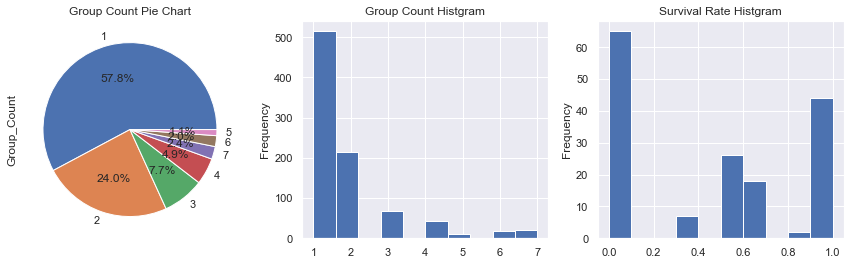

In [67]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
train['Group_Count'].value_counts().plot.pie(
    ax=axes[0], title='Group Count Pie Chart', autopct="%1.1f%%")
train['Group_Count'].plot.hist(ax=axes[1], title='Group Count Histgram')
train.query('Group_Count > 2')['Group_Target'].plot.hist(
    ax=axes[2], title='Survival Rate Histgram')
plt.show()


/Users/manokukenta/.anyenv/envs/pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/plotting/_matplotlib/hist.py:370: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


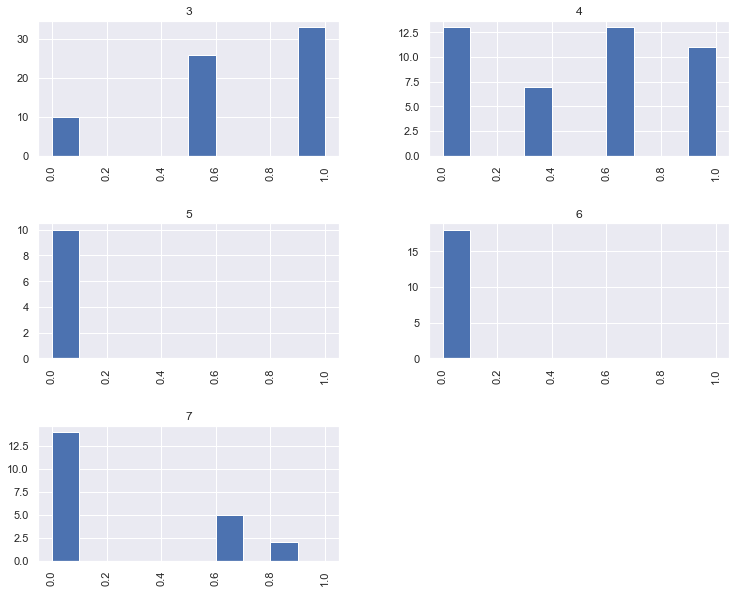

In [68]:
_, ax = plt.subplots(figsize=(12, 10))
train.query('Group_Count > 2').Group_Target.hist(
    ax=ax, by=train['Group_Count'], range=(0, 1))
plt.show()


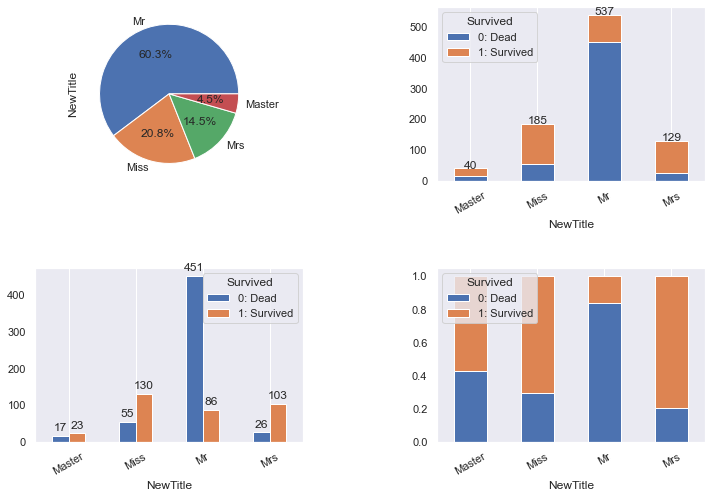

In [69]:
output_bars(train, 'NewTitle')


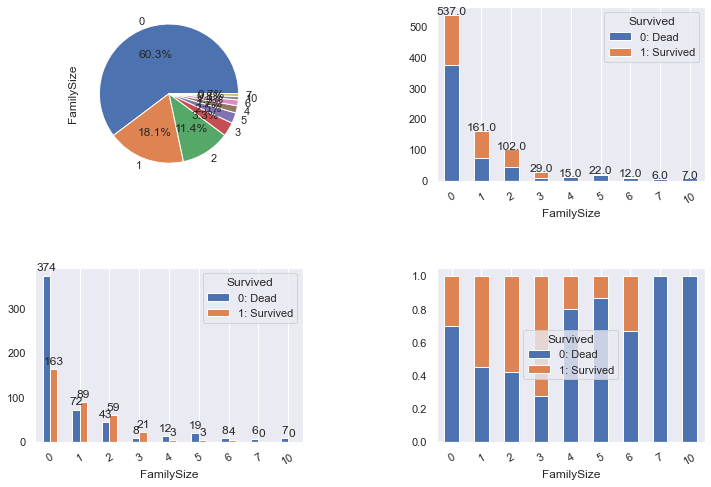

In [70]:
output_bars(train, 'FamilySize')


In [71]:
# 学習曲線出力
def output_learning_curve(ax, x_all, y_all, gscv):
    training_sizes, train_scores, test_scores = learning_curve(gscv.best_estimator_,
                                                               x_all, y_all, cv=5,
                                                               train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.plot(training_sizes, train_scores.mean(axis=1), label="training scores")
    ax.plot(training_sizes, test_scores.mean(axis=1), label="test scores")
    ax.legend(loc="best")
    ax.set_title('Learning Curve')


In [72]:
# 適合率-再現率グラフ出力
def output_pr_curve(ax, y_test, y_pred):
    # ある閾値の時の適合率、再現率, 閾値の値を取得
    precisions, recalls, thresholds = precision_recall_curve(
        y_test, y_pred[:, 1])

    # 0から1まで0.05刻みで○をプロット
    for i in range(21):
        close_point = np.argmin(np.abs(thresholds - (i * 0.05)))
        ax.plot(precisions[close_point], recalls[close_point], 'o')

    # 適合率-再現率曲線
    ax.plot(precisions, recalls)
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    ax.set_title('Precision Recall Curve')


In [73]:
def output_graphs(gscv, X, X_test):

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # Confusion Matrix 出力
    plot_confusion_matrix(gscv.best_estimator_, X, y, ax=axes[0, 0], display_labels=[
                          '0: Dead', '1: Survived'])

    # Grid Searchの結果出力
    result = pd.DataFrame(gscv.cv_results_).set_index('params')
    result.sort_values('rank_test_score', ascending=False).head(
        10)['mean_test_score'].plot.barh(ax=axes[0, 1], grid=True)
    axes[0, 1].set_xlim(result['mean_test_score'].min() *
                        0.9, result['mean_test_score'].max() * 1.1)

    # Feature Importance 出力(分類器にあれば)
    axes[0, 2].set_title('Feature Importance/ Coef Top 10')
    if hasattr(gscv.best_estimator_, 'feature_importances_'):
        importances = pd.DataFrame(
            {'Importance': gscv.best_estimator_.feature_importances_}, index=X_test.columns)
        importances.sort_values('Importance', ascending=False).head(10).sort_values(
            'Importance', ascending=True).plot.barh(ax=axes[0, 2], grid=True)
    if hasattr(gscv.best_estimator_, 'coef_'):
        importances = pd.DataFrame(
            {'Coef': gscv.best_estimator_.coef_[0]}, index=X_test.columns)
        importances.sort_values('Coef', ascending=False).head(10).sort_values(
            'Coef', ascending=True).plot.barh(ax=axes[0, 2], grid=True)

    # ROC曲線出力
    plot_roc_curve(gscv.best_estimator_, X, y, ax=axes[1, 0])
    axes[1, 0].set_title('ROC(Receiver Operating Characteristic) Curve')

    # 適合率-再現率グラフ出力
    y_pred = gscv.best_estimator_.predict_proba(X)
    output_pr_curve(axes[1, 1], y, y_pred)

    # 学習曲線出力
    output_learning_curve(axes[1, 2], X, y, gscv)

    plt.show()


In [74]:
def fit(classifier, parameters):
    gscv = GridSearchCV(classifier, parameters, cv=5)
    gscv.fit(X, y)

    print('Grid Search Best parameters:', gscv.best_params_)
    print('Grid Search Best validation score:', gscv.best_score_)
    print('Grid Search Best training score:', gscv.best_estimator_.score(X, y))

    predictions = gscv.best_estimator_.predict(X_test)

    X_pred = gscv.best_estimator_.predict(X)
    print('\n', classification_report(y, X_pred))

    output_graphs(gscv, X, X_test)

    return gscv


In [75]:
features = ["Group_Count", "Group_Target", 'PclassEncoded', 'SexEncoded',
            "FamilySize", 'x0_Q', 'x0_S', 'x1_Miss', 'x1_Mr', 'x1_Mrs']
y = train["Survived"].astype('int')
tmp_sr = test['PassengerId']
X = train[features]
X_test = test[features]


Grid Search Best parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
Grid Search Best validation score: 0.8619232942062645
Grid Search Best training score: 0.8630751964085297

               precision    recall  f1-score   support

           0       0.85      0.94      0.89       549
           1       0.88      0.74      0.81       342

    accuracy                           0.86       891
   macro avg       0.87      0.84      0.85       891
weighted avg       0.86      0.86      0.86       891



/Users/manokukenta/.anyenv/envs/pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/manokukenta/.anyenv/envs/pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


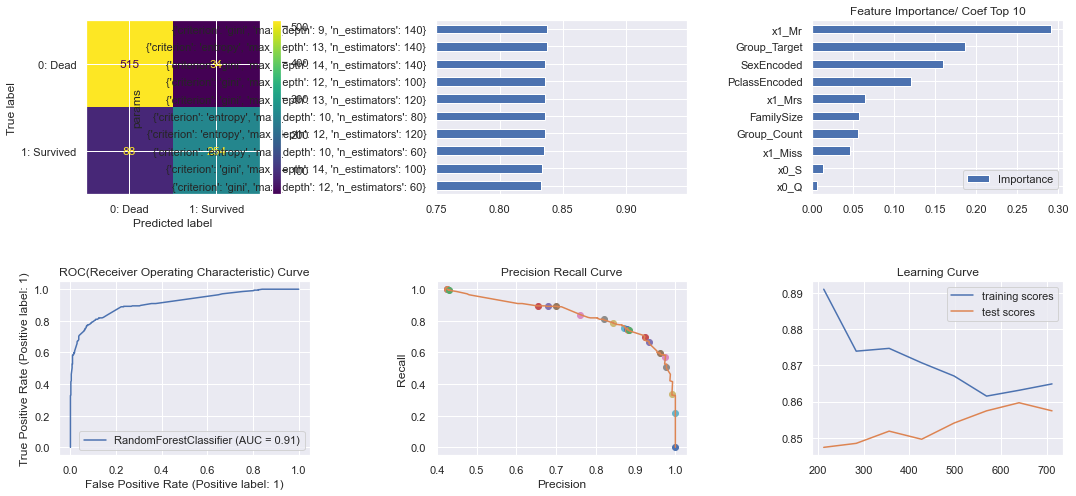

In [77]:
parameters = [{'max_depth': np.arange(4, 15, 1), 'n_estimators': np.arange(
    60, 141, 20), 'criterion': ['gini', 'entropy']}]
rf_gscv = fit(RandomForestClassifier(), parameters)


In [78]:
predictions = rf_gscv.best_estimator_.predict(X_test)
output = pd.DataFrame({'PassengerId': tmp_sr, 'Survived': predictions})
output.to_csv('./output/my_submission.csv', index=False)
